# CS231a PSET 4

You can use this colab notebook to write your code in, which could save you the trouble of having to set up Python or installing packages.

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# the files containing the '.npy' files needed for problem 2
# e.g. '/content/drive/MyDrive/cs231a'
FOLDERNAME = 'cs231a/ps4_code'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/MyDrive/$FOLDERNAME
print('Files in this folder:')
%ls .

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1v-0n-LcihQJbpWAyrDC-9tjJXWvDa8mS/cs231a/ps4_code
Files in this folder:
data/                               p1/    p4.py           PSET4.ipynb
LearnedObservationModel_Copy.ipynb  p2.py  plot_helper.py  __pycache__/
LearnedObservationModel.ipynb       p3.py  ps4.pdf         trained_model.pth


# Problem 1: Unsupervised Monocular Depth Estimation


This the notebook you can use to complete problem 1. It's not necessary, but it may be helpful so that you don't need to install new python packges. To get going, let's get access to the data and code as in the prior problems. You can also skip this step and just upload the files directly using the files tab, though any changes you make will be gone if you close the tab or the colab runtime ends.

Then, you should be able to run the following with no problem.

In [2]:
# Dataloading

import importlib

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.utils as tvutils
import torch.nn.functional as F

from p1 import problems

data = np.load('p1/data.npz')
disparities = data['disparities']
left_images = data['left_image']
right_images = data['right_image']
left_image_t = torch.from_numpy(left_images[0])
right_image_t = torch.from_numpy(right_images[0])

## a. Horizontal flip data augmentation
Before we get started, we would like you to implement a data augmentation function for stereo images that randomly flips the given image horizontally. In neural networks, data augmentation takes a crucial role in better generalization of the problem. One of the most common data augmentation when using 2D images as input is to randomly flip the image horizontally. One interesting difference in our problem setup is that we take a pair of rectified stereo images as input. In order to maintain the stereo relationship after the horizontal flip, it requires a special attention. Please fill in the code in StereoRandomFlip to implement the data augmentation function.

Following is a visualization of a sample of input stereo images. Please fill in the function that correctly flip the stereo image for data augmentation.

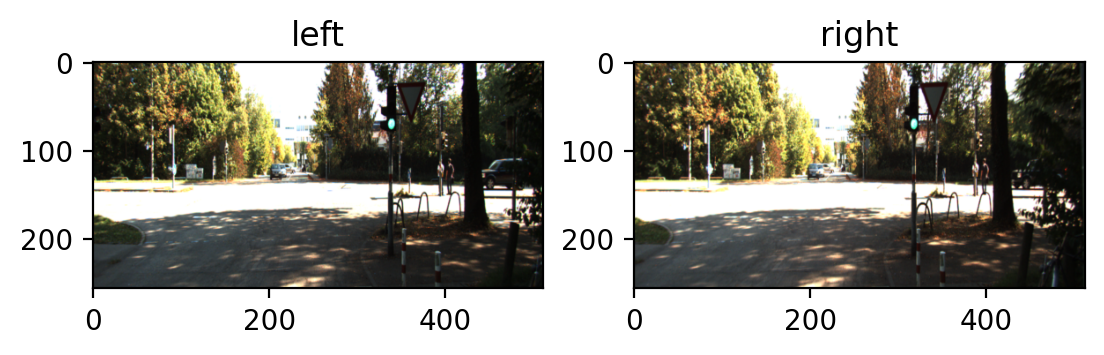

In [3]:
f, ax = plt.subplots(1, 2, dpi=200)
ax[0].imshow(np.transpose(left_image_t, (1, 2, 0)))
ax[0].title.set_text('left')
ax[1].imshow(np.transpose(right_image_t, (1, 2, 0)))
ax[1].title.set_text('right')

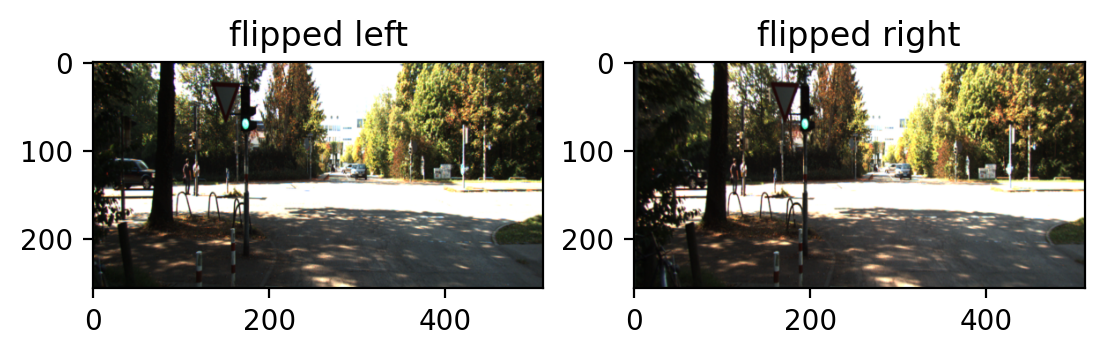

In [4]:
importlib.reload(problems)

transform_flip = problems.StereoRandomFlip()
flipped_left_t, flipped_right_t = transform_flip._flip(left_image_t, right_image_t)
f, ax = plt.subplots(1, 2, dpi=200)
ax[0].imshow(np.transpose(flipped_left_t, (1, 2, 0)))
ax[0].title.set_text('flipped left')
ax[1].imshow(np.transpose(flipped_right_t, (1, 2, 0)))
ax[1].title.set_text('flipped right')

## c. Implement bilinear sampler

Next, implement a function bilinear_sampler which shifts the given horizontally given the disparity. The core idea of unsupervised monocular depth estimation is that we can generate left image from right and vice versa by sampling rectified images horizontally using the disparity. We will ask you to implement a function that simply samples image with horizontal displacement as given by the input disparity. Fill in the bilinear_sampler method at p5/problems.py

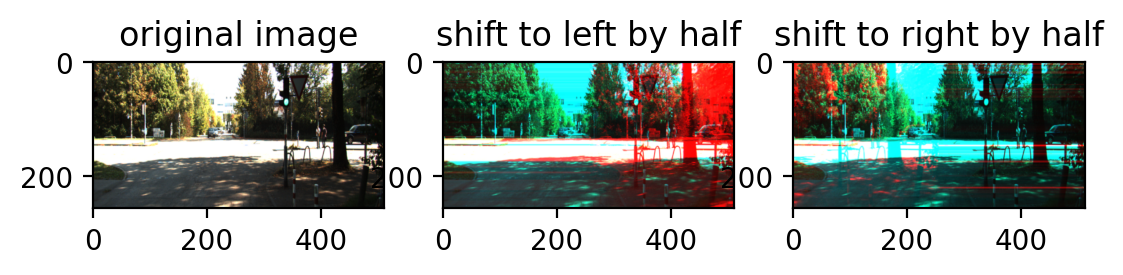

In [5]:
importlib.reload(problems)

img_left = torch.from_numpy(left_images)
img_right = torch.from_numpy(right_images)

shift_left = torch.ones_like(img_left) * 0.5
shift_right = torch.ones_like(img_left) * -0.5

img_shift_left_half = problems.bilinear_sampler(img_left, shift_left)
img_shift_right_half = problems.bilinear_sampler(img_left, shift_right)

f, ax = plt.subplots(1, 3, dpi=200)
ax[0].imshow(np.transpose(img_left[0], (1, 2, 0)))
ax[0].title.set_text('original image')
ax[1].imshow(np.transpose(img_shift_left_half[0], (1, 2, 0)))
ax[1].title.set_text('shift to left by half')
ax[2].imshow(np.transpose(img_shift_right_half[0], (1, 2, 0)))
ax[2].title.set_text('shift to right by half')

## d. Implement left/right image generator.

Finally, implement functions generate_image_right and generate_image_left which generates right view of the image from left image using the disparity and vice versa. This will be a simple one-liner that applies bilinear_sampler.

In [6]:
importlib.reload(problems)

img_left = torch.from_numpy(left_images)
img_right = torch.from_numpy(right_images)
disp_l = torch.from_numpy(disparities[0, 0]).unsqueeze(0).unsqueeze(0)
disp_r = torch.from_numpy(disparities[0, 1]).unsqueeze(0).unsqueeze(0)

img_left_est = problems.generate_image_left(img_right, disp_l)
img_right_est = problems.generate_image_right(img_left, disp_r)
disp_left_est = problems.generate_image_left(disp_r, disp_l)
disp_right_est = problems.generate_image_right(disp_l, disp_r)

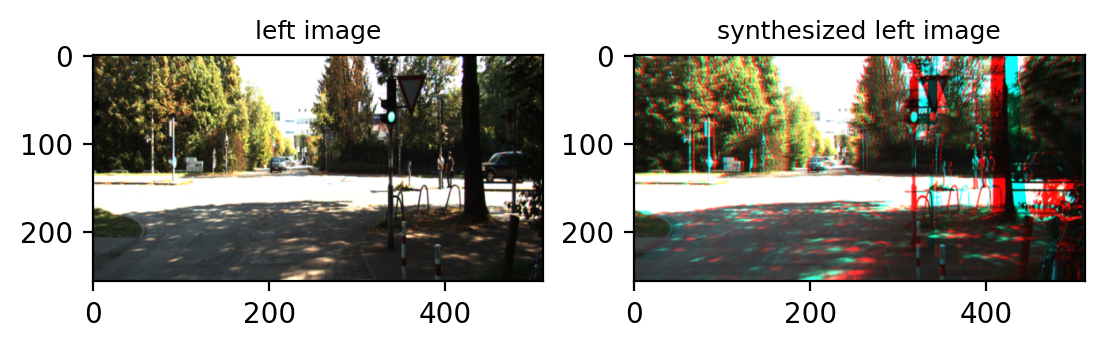

In [7]:
f, ax = plt.subplots(1, 2, dpi=200)
ax[0].imshow(np.transpose(img_left[0], (1, 2, 0)))
ax[0].title.set_text('left image')
ax[0].title.set_fontsize(9)
ax[1].imshow(np.transpose(img_left_est[0], (1, 2, 0)))
ax[1].title.set_text('synthesized left image')
ax[1].title.set_fontsize(9)

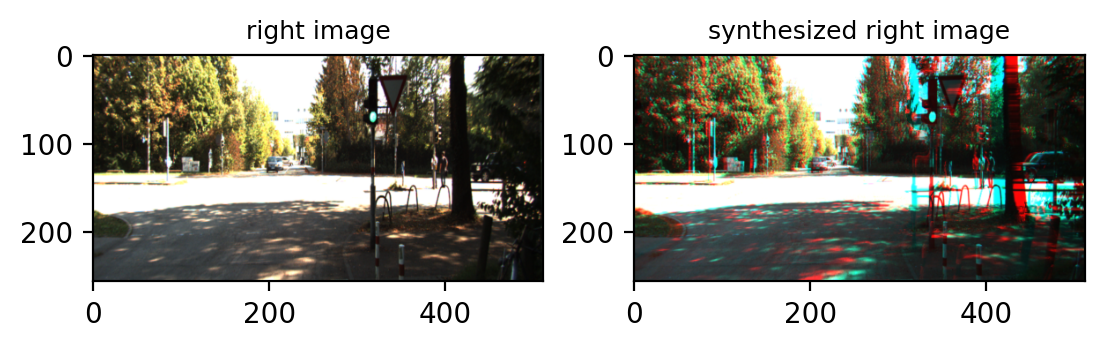

In [8]:
f, ax = plt.subplots(1, 2, dpi=200)
ax[0].imshow(np.transpose(img_right[0], (1, 2, 0)))
ax[0].title.set_text('right image')
ax[0].title.set_fontsize(9)
ax[1].imshow(np.transpose(img_right_est[0], (1, 2, 0)))
ax[1].title.set_text('synthesized right image')
ax[1].title.set_fontsize(9)

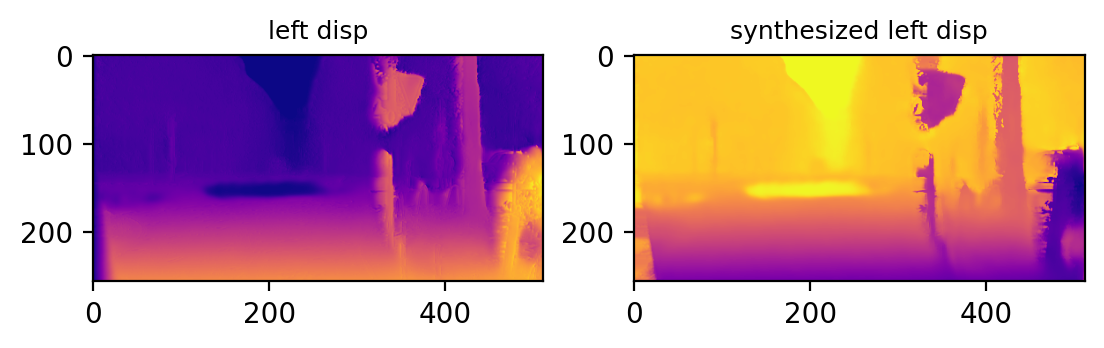

In [9]:
f, ax = plt.subplots(1, 2, dpi=200)
ax[0].imshow(disparities[0, 0], cmap='plasma')
ax[0].title.set_text('left disp')
ax[0].title.set_fontsize(9)
ax[1].imshow(disp_left_est[0, 0], cmap='plasma')
ax[1].title.set_text('synthesized left disp')
ax[1].title.set_fontsize(9)

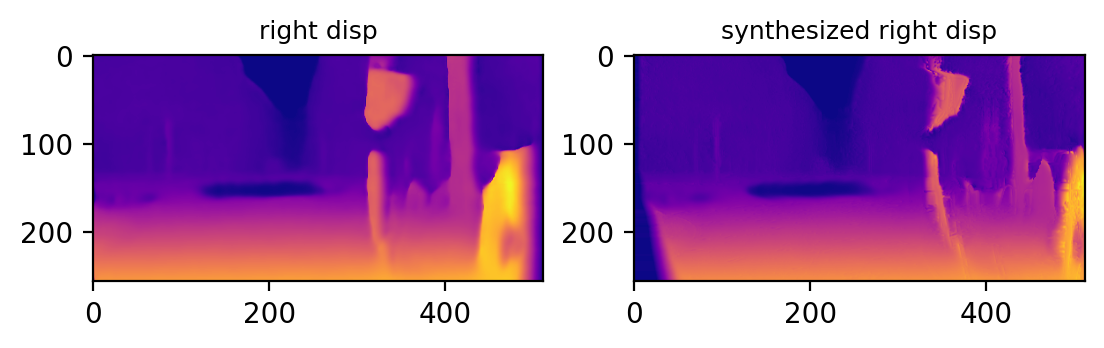

In [10]:
f, ax = plt.subplots(1, 2, dpi=200)
ax[0].imshow(disparities[0, 1], cmap='plasma')
ax[0].title.set_text('right disp')
ax[0].title.set_fontsize(9)
ax[1].imshow(disp_right_est[0, 0], cmap='plasma')
ax[1].title.set_text('synthesized right disp')
ax[1].title.set_fontsize(9)

# Problem 2: Extended Kalman Filter with a Nonlinear Observation Model

First, we need to be able to access the data for this problem. Run the following:

Now, you can fill out the logic for this problem. Once done, copy it to p2.py for submission to Gradescope.

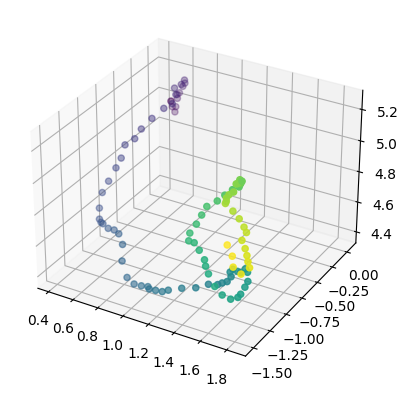

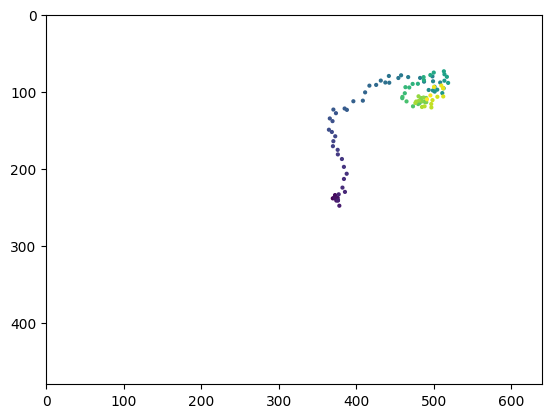

HERE


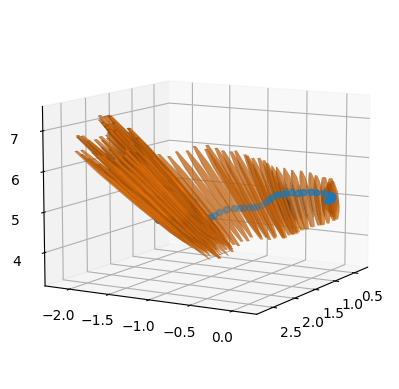

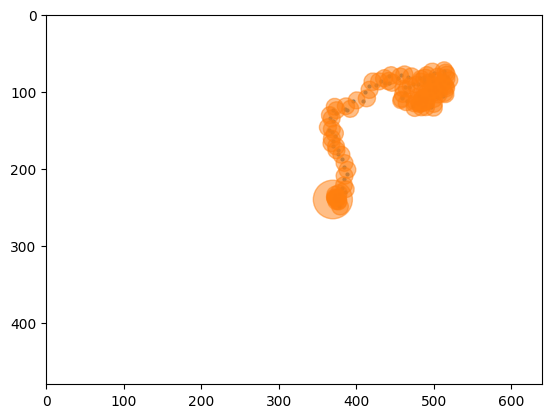

In [11]:
import numpy as np

class Q2_solution(object):

  @staticmethod
  def system_matrix():
    """ Implement the answer to Q2A here.
    Output:
      A: 6x6 numpy array for the system matrix.
    """
    A = np.eye(6)
    # TODO fill in values for A below
    # Hint: only 9 entries should be non-zero, with values 1, 0.1, and 0.8
    A[0][3] = 0.1
    A[1][4] = 0.1
    A[2][5] = 0.1
    A[3][3] = 0.8
    A[4][4] = 0.8
    A[5][5] = 0.8
    return A

  @staticmethod
  def process_noise_covariance():
    """ Implement the covariance matrix Q for process noise.
    Output:
      Q: 6x6 numpy array for the covariance matrix.
    """
    Q = np.eye(6)
    # TODO fill in values for Q below
    # Hint: only 3 entries should be non-zero, and all should equal 0.05
    Q = np.diag([0,0,0,0.05, 0.05, 0.05])
    return Q

  @staticmethod
  def observation_noise_covariance():
    """ Implement the covariance matrix R for observation noise.
    Output:
      R: 2x2 numpy array for the covariance matrix.
    """
    R = np.eye(2)
    # TODO fill in values for R below
    # Hint: only 2 entries should be non-zero, and all should equal 5.0
    R = np.diag([5.0, 5.0])
    return R

  @staticmethod
  def observation(state):
    """ Implement the function h, from state to noise-less observation. (Q2B)
    Input:
      state: (6,) numpy array representing state.
    Output:
      obs: (2,) numpy array representing observation.
    """
    # Hint: you should use the camera intrinsics here
    K = np.array([[500., 0.,   320.],
                  [0.,   500., 240.],
                  [0.,   0.,   1.]], dtype=np.float64)

    # Get image projection and convert to euclidean
    obs = np.dot(K, state[:3])
    obs = (obs / obs[-1])[:2]
    return obs

  def simulation(self, T=100):
    """ simulate with fixed start state for T timesteps.
    Input:
      T: an integer (=100).
    Output:
      states: (T,6) numpy array of states, including the given start state.
      observations: (T,2) numpy array of observations, Including the observation of start state.
    Note:
      We have set the random seed for you. Please only use np.random.multivariate_normal to sample noise.
      Keep in mind this function will be reused for Q3 by inheritance.
    """
    x_0 = np.array([0.5, 0.0, 5.0, 0.0, 0.0, 0.0])
    states = [x_0]
    A = self.system_matrix()
    Q = self.process_noise_covariance()
    R = self.observation_noise_covariance()
    z_0 = self.observation(x_0) + np.random.multivariate_normal(np.zeros((R.shape[0],)), R)
    observations = [z_0]
    for t in range(1,T):
      process_noise = np.random.multivariate_normal(np.zeros((Q.shape[0],)), Q)
      xt = np.dot(A, states[-1]) + process_noise
      zt = self.observation(xt) + np.random.multivariate_normal(np.zeros((R.shape[0],)), R)
      states.append(xt)
      observations.append(zt)
    return np.array(states), np.array(observations)

  @staticmethod
  def observation_state_jacobian(x):
    """ Implement your answer for Q2D.
    Input:
      x: (6,) numpy array, the state we want to do jacobian at.
    Output:
      H: (2,6) numpy array, the jacobian of the observation model w.r.t state.
    """
    H = np.zeros((2,6))
    # Hint: four values in the Jacobian should be non-zero
    K = np.array([[500., 0.,   320.],
                  [0.,   500., 240.],
                  [0.,   0.,   1.  ]], dtype=np.float64)

    H[0:] = [K[0,0]/x[2],  0., -K[0,0]*x[0]/(x[2]**2), 0., 0., 0.]
    H[1:] = [0.,  K[1,1]/x[2], -K[1,1]*x[1]/(x[2]**2), 0., 0., 0.]
    return H

  def EKF(self, observations):
    """ Implement Extended Kalman filtering (Q2E)
    Input:
      observations: (N,2) numpy array, the sequence of observations. From T=1.
      mu_0: (6,) numpy array, the mean of state belief after T=0
      sigma_0: (6,6) numpy array, the covariance matrix for state belief after T=0.
    Output:
      state_mean: (N,6) numpy array, the filtered mean state at each time step. Not including the
                  starting state mu_0.
      state_sigma: (N,6,6) numpy array, the filtered state covariance at each time step. Not including
                  the starting state covarance matrix sigma_0.
      predicted_observation_mean: (N,2) numpy array, the mean of predicted observations. Start from T=1
      predicted_observation_sigma: (N,2,2) numpy array, the covariance matrix of predicted observations. Start from T=1
    Note:
      Keep in mind this function will be reused for Q2 by inheritance.
    """
    mu_0 = np.array([0.5, 0.0, 5.0, 0.0, 0.0, 0.0])
    sigma_0 = np.eye(6)*0.01
    sigma_0[3:,3:] = 0.0
    A = self.system_matrix()
    Q = self.process_noise_covariance()
    R = self.observation_noise_covariance()
    state_mean = [mu_0]
    state_sigma = [sigma_0]
    predicted_observation_mean = []
    predicted_observation_sigma = []
    for ob in observations:
        mu_bar_next = np.dot(A, state_mean[-1]) # TODO fill this in
        sigma_bar_next = np.dot(A, np.dot(state_sigma[-1], A.T)) + Q # TODO fill this in
        H = self.observation_state_jacobian(mu_bar_next) # TODO fill this in
        kalman_gain_numerator = np.dot(sigma_bar_next, H.T) # TODO fill this in
        kalman_gain_denominator = np.dot(H, np.dot(sigma_bar_next, H.T)) + R # TODO fill this in
        kalman_gain = np.dot(kalman_gain_numerator, np.linalg.inv(kalman_gain_denominator))  # TODO fill this in
        expected_observation = self.observation(mu_bar_next) # TODO fill this in
        mu_next = mu_bar_next + np.dot(kalman_gain, (ob - expected_observation).T) # TODO fill this in
        sigma_next = np.dot((np.eye(6, dtype=np.float64) - np.dot(kalman_gain, H)), sigma_bar_next) # TODO fill this in
        state_mean.append(mu_next)
        state_sigma.append(sigma_next)
        predicted_observation_mean.append(expected_observation)
        predicted_observation_sigma.append(kalman_gain_denominator)
    return np.array(state_mean[1:]), np.array(state_sigma[1:]), np.array(predicted_observation_mean), np.array(predicted_observation_sigma)


if __name__ == "__main__":
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from plot_helper import draw_2d, draw_3d

    np.random.seed(402)
    solution = Q2_solution()
    states, observations = solution.simulation()
    # plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(states[:,0], states[:,1], states[:,2], c=np.arange(states.shape[0]))
    plt.show()

    fig = plt.figure()
    plt.scatter(observations[:,0], observations[:,1], c=np.arange(states.shape[0]), s=4)
    plt.xlim([0,640])
    plt.ylim([0,480])
    plt.gca().invert_yaxis()
    plt.show()
    print("HERE")
    observations = np.load('./data/Q2E_measurement.npy')
    filtered_state_mean, filtered_state_sigma, predicted_observation_mean, predicted_observation_sigma = \
        solution.EKF(observations)
    # plotting
    true_states = np.load('./data/Q2E_state.npy')
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(true_states[:,0], true_states[:,1], true_states[:,2], c='C0')
    for mean, cov in zip(filtered_state_mean, filtered_state_sigma):
        draw_3d(ax, cov[:3,:3], mean[:3])
    ax.view_init(elev=10., azim=30)
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(observations[:,0], observations[:,1], s=4)
    for mean, cov in zip(predicted_observation_mean, predicted_observation_sigma):
        draw_2d(ax, cov, mean)
    plt.xlim([0,640])
    plt.ylim([0,480])
    plt.gca().invert_yaxis()
    plt.show()

# Problem 3: From Monocular to Stereo Vision [Extra Credit]

First, make sure you have already run the code block for having access to numpy files from Problem 2. Then, complete this code and then copy it to Q3.py for submission to Gradescope.

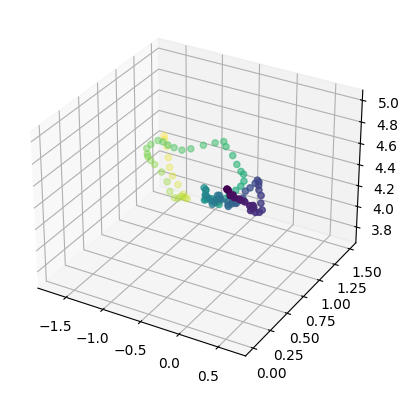

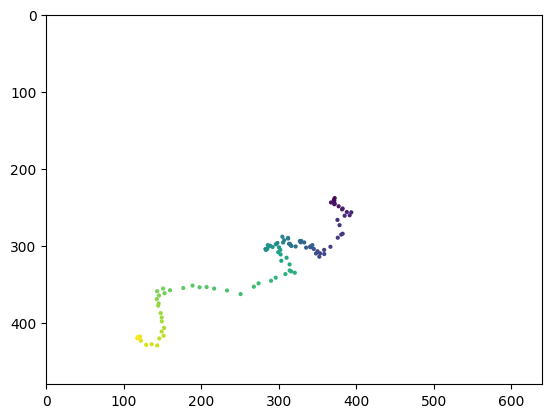

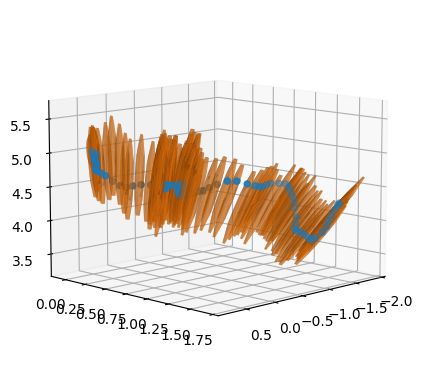

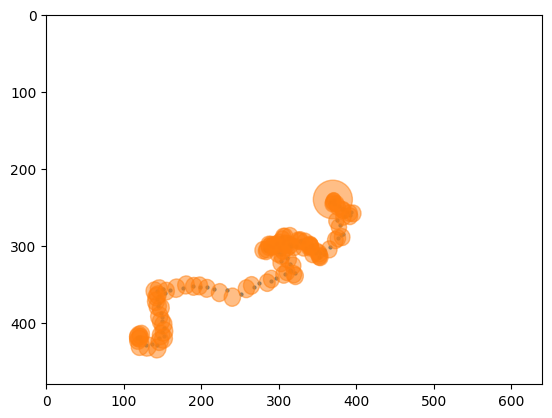

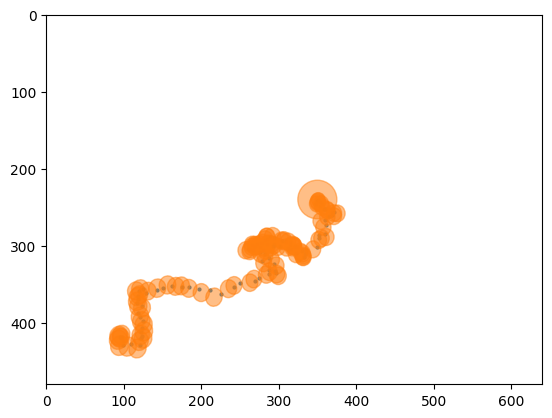

In [12]:
import numpy as np
# from p2 import Q2_solution # IMPORTANT: uncomment when copying to p2.py


class Q3_solution(Q2_solution):

  @staticmethod
  def observation(x):
    """ Implement Q3A. Observation function without noise.
    Input:
      x: (6,) numpy array representing the state.
    Output:
      obs: (3,) numpy array representing the observation (u,v,d).
    Note:
      we define disparity to be possitive.
    """
    # Hint: this should be similar to your implemention in Q1, but with two cameras
    K = np.array([[500, 0, 320, 0],
                  [0, 500, 240, 0],
                  [0, 0, 1, 0]])
    u_l, v_l, z_l = x[0], x[1], x[2]
    disparity = 0.2 * 500 / x[2]
    hom_3d = np.array([u_l, v_l, z_l, 1])
    hom_2d = K.dot(hom_3d).T
    point_2d = hom_2d / hom_2d[2]
    obs = np.array([point_2d[0], point_2d[1], disparity])
    return obs

  @staticmethod
  def observation_state_jacobian(x):
    """ Implement Q3B. The jacobian of observation function w.r.t state.
    Input:
      x: (6,) numpy array, the state to take jacobian with.
    Output:
      H: (3,6) numpy array, the jacobian H.
    """
    H = np.zeros((3,6))

    tx = x[0]
    ty = x[1]
    tz = x[2]
    b = 0.2

    J = np.array([[500 / tz, 0, 500 * -tx / tz ** 2, 0, 0, 0],
                         [0, 500 / tz, 500 * -ty / tz ** 2, 0, 0, 0],
                         [0 ,0, b*-500/tz**2, 0, 0, 0]])
    return J

  @staticmethod
  def observation_noise_covariance():
    """ Implement Q3C here.
    Output:
      R: (3,3) numpy array, the covariance matrix for observation noise.
    """
    R = np.array([[5., 0., 5.],
                 [0., 5., 0.],
                 [5., 0., 10.]])
    return R


if __name__ == "__main__":
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from plot_helper import draw_2d, draw_3d

    np.random.seed(315)
    solution = Q3_solution()
    states, observations = solution.simulation()
    # plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(states[:,0], states[:,1], states[:,2], c=np.arange(states.shape[0]))
    plt.show()

    fig = plt.figure()
    plt.scatter(observations[:,0], observations[:,1], c=np.arange(states.shape[0]), s=4)
    plt.xlim([0,640])
    plt.ylim([0,480])
    plt.gca().invert_yaxis()
    plt.show()

    observations = np.load('./data/Q3D_measurement.npy')
    filtered_state_mean, filtered_state_sigma, predicted_observation_mean, predicted_observation_sigma = \
        solution.EKF(observations)
    # plotting
    true_states = np.load('./data/Q3D_state.npy')
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(true_states[:,0], true_states[:,1], true_states[:,2], c='C0')
    for mean, cov in zip(filtered_state_mean, filtered_state_sigma):
        draw_3d(ax, cov[:3,:3], mean[:3])
    ax.view_init(elev=10., azim=45)
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(observations[:,0], observations[:,1], s=4)
    for mean, cov in zip(predicted_observation_mean, predicted_observation_sigma):
        draw_2d(ax, cov[:2,:2], mean[:2])
    plt.xlim([0,640])
    plt.ylim([0,480])
    plt.gca().invert_yaxis()
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(observations[:,0]-observations[:,2], observations[:,1], s=4)
    for mean, cov in zip(predicted_observation_mean, predicted_observation_sigma):
        # TODO find out the mean and convariance for (u^R, v^R).
        right_cov = np.array([[cov[0,0], cov[0,1] - cov[2,1]],
                              [cov[1,0] - cov[1,2], cov[1,1]]])
        right_mean = np.array([mean[0] - mean[2], mean[1]])
        draw_2d(ax, right_cov, right_mean)
    plt.xlim([0,640])
    plt.ylim([0,480])
    plt.gca().invert_yaxis()
    plt.show()


# Problem 4: Linear Kalman Filter with a Learned Inverse Observation Model
First, make sure you have already run the code block for having access to numpy files from Problem 3 if using colab.
Then, complete this code after running the cells in LearnedObervationModel.ipynb and then copy it to p4.py for submission to Gradescope.

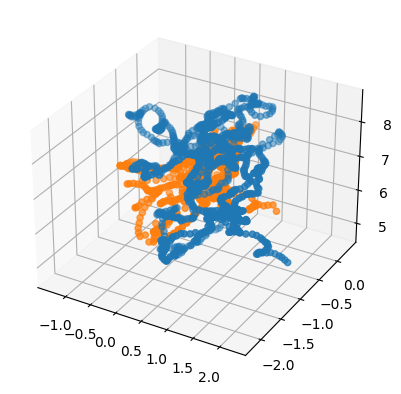

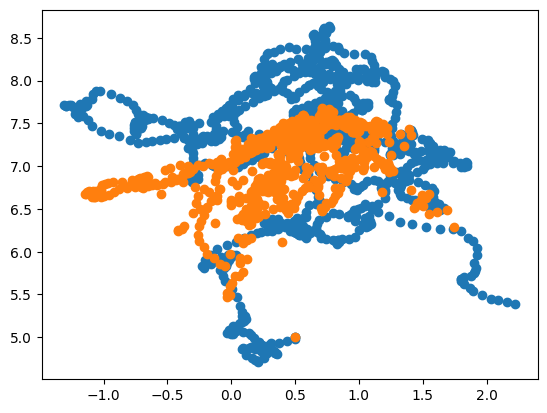

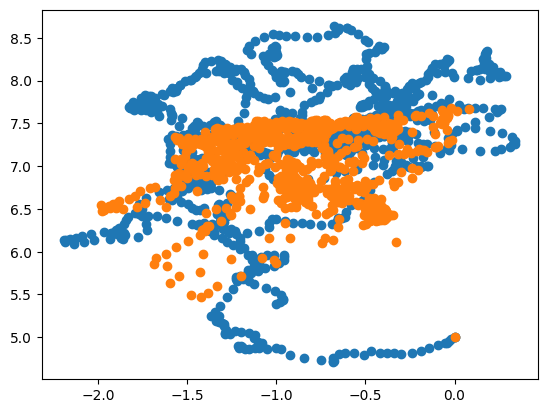

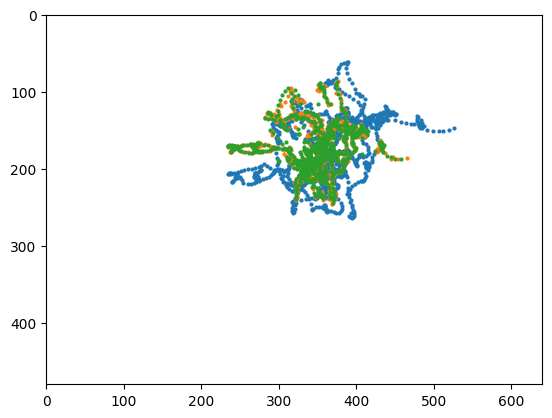

In [22]:
import numpy as np
import pdb

# TODO fill out the following class, reusing your implementation from the
# prior problems
class Q4_solution(object):

  @staticmethod
  def system_matrix():
    """
    Output:
      A: 6x6 numpy array for the system matrix.
    """
    # Hint: this is the same as in part A
    A = np.eye(6)
    # x = [px, py, pz, vx, vy, vz]
    dt = 0.1
    v = 0.8
    A[0, 3] = dt
    A[1, 4] = dt
    A[2, 5] = dt
    A[3, 3] = v
    A[4, 4] = v
    A[5, 5] = v
    return A

  @staticmethod
  def process_noise_covariance():
    """
    Output:
      Q: 6x6 numpy array for the covariance matrix.
    """
    # Hint: this is the same as in part A
    Q = np.eye(6)
    Q[0, 0] = 0.00
    Q[1, 1] = 0.00
    Q[2, 2] = 0.00
    Q[3, 3] = 0.05
    Q[4, 4] = 0.05
    Q[5, 5] = 0.05
    return Q

  @staticmethod
  def observation_noise_covariance():
    """
    Output:
      R: 2x2 numpy array for the covariance matrix.
    """
    sigma = np.diag([0.005, 0.005, 0.01])
    return sigma

  @staticmethod
  def observation_state_jacobian():
      """ Implement your answer for Q1D.
      Input:
        x: (6,) numpy array, the state we want to do jacobian at.
      Output:
        H: (2,6) numpy array, the jacobian of the observation model w.r.t state.
      """
      # as per Ed post# 655, we have to have H = C = [I | 0]
      H1 = np.eye(3)
      H2 = np.zeros((3, 3))
      H = np.hstack([H1, H2])
      return H

  @staticmethod
  def observation(x):
      """ Implement your answer for Q1D.
      Input:
        x: (6,) numpy array, the state we want to do jacobian at.
      Output:
        H: (2,6) numpy array, the jacobian of the observation model w.r.t state.
      """
      x = x[0:3]
      return x

  def KF(self, observations, mu_0, sigma_0, remove_outliers):
    """ Implement Kalman filtering
    Input:
      observations: (N,2) numpy array, the sequence of observations. From T=1.
      mu_0: (6,) numpy array, the mean of state belief after T=0
      sigma_0: (6,6) numpy array, the covariance matrix for state belief after T=0.
      remove_outliers: bool, whether to remove outliers
    Output:
      state_mean: (N,6) numpy array, the filtered mean state at each time step. Not including the
                  starting state mu_0.
      state_sigma: (N,6,6) numpy array, the filtered state covariance at each time step. Not including
                  the starting state covarance matrix sigma_0.
      predicted_observation_mean: (N,2) numpy array, the mean of predicted observations. Start from T=1
      predicted_observation_sigma: (N,2,2) numpy array, the covariance matrix of predicted observations. Start from T=1
    """
    A = self.system_matrix()
    Q = self.process_noise_covariance()
    R = self.observation_noise_covariance()
    state_mean = [mu_0]
    state_sigma = [sigma_0]
    predicted_observation_mean = []
    predicted_observation_sigma = []
    for ob in observations:
        mu_bar_next = A.dot(state_mean[-1])  # TODO fill this in
        sigma_bar_next = A.dot(state_sigma[-1]).dot(A.T) + Q  # TODO fill this in
        H = self.observation_state_jacobian()  # TODO fill this in
        kalman_gain_numerator = sigma_bar_next.dot(H.T)  # TODO fill this in
        kalman_gain_denominator = H.dot(kalman_gain_numerator) + R  # TODO fill this in
        kalman_gain = kalman_gain_numerator.dot(np.linalg.inv(kalman_gain_denominator))  # TODO fill this in
        expected_observation = self.observation(mu_bar_next)  # TODO fill this in
        mu_next = mu_bar_next + kalman_gain.dot(ob - expected_observation)  # TODO fill this in
        sigma_next = (np.eye(6) - kalman_gain.dot(H)).dot(sigma_bar_next)  # TODO fill this in

        # EXTRA CREDIT
        # deviation = np.any((abs(expected_observation - ob) / ob) ** 100)  # TODO fill this in
        deviation = np.sqrt(np.dot((ob - expected_observation).T, np.dot(np.linalg.inv(kalman_gain_denominator), (ob - expected_observation))))
        if not filter_outliers or deviation <= 25:  # part D
            mu_next = mu_bar_next + kalman_gain.dot(ob - expected_observation)  # TODO fill this in
            sigma_next = (np.eye(6) - kalman_gain.dot(H)).dot(sigma_bar_next)
            # TODO fill this in
        else:
            mu_next = mu_bar_next  # TODO fill this in
            sigma_next = sigma_bar_next
        state_mean.append(mu_next)
        state_sigma.append(sigma_next)
        predicted_observation_mean.append(expected_observation)
        predicted_observation_sigma.append(kalman_gain_denominator)
    return state_mean, state_sigma, predicted_observation_mean, predicted_observation_sigma


if __name__ == "__main__":
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from plot_helper import draw_2d, draw_3d
    part_b_data = False
    filter_outliers = True

    solution = Q4_solution()

    if part_b_data:
        state_positions = np.load('data/Q4B_data/Q4B_positions_gt.npy')
        observations = np.load('./data/Q4B_predictions.npy')
    else:
        state_positions = np.load('data/Q4D_data/Q4D_positions_gt.npy')
        observations = np.load('./data/Q4D_predictions.npy')

    state_0 = np.concatenate([state_positions[0], np.zeros(3)])
    sigma_0 = np.eye(6)*0.01
    sigma_0[3:,3:] = 0.0
    state_mean, state_sigma, predicted_observation_mean, predicted_observation_sigma = \
        solution.KF(observations[1:], state_0, sigma_0, filter_outliers)
    state_mean = np.array(state_mean)
    dev = np.linalg.norm(state_positions-state_mean[:,:3], axis=1)
    err = np.linalg.norm(state_positions-observations[:,:3], axis=1)

    # 3D plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(state_mean[:,0], state_mean[:,1], state_mean[:,2], c='C1')
    ax.scatter(state_positions[:,0], state_positions[:,1], state_positions[:,2], c='C0')
    plt.show()

    if not part_b_data:
      # 2d plotting
      fig = plt.figure()
      plt.scatter(state_positions[:,0], state_positions[:,2], c='C0')
      state_mean = np.array(state_mean)
      plt.scatter(state_mean[:,0], state_mean[:,2], c='C1')
      plt.show()

      fig = plt.figure()
      plt.scatter(state_positions[:,1], state_positions[:,2], c='C0')
      state_mean = np.array(state_mean)
      plt.scatter(state_mean[:,1], state_mean[:,2], c='C1')
      plt.show()

      if filter_outliers:
          def projection(points_3d):
              intrinsic = np.array([[500,0,320],[0,500,240],[0,0,1]])
              points_proj = np.dot(points_3d, intrinsic.transpose())
              points_proj = points_proj[:,:2]/points_proj[:,2:3]
              return points_proj

          gt_state_proj = projection(state_positions)
          detection_proj = projection(observations)
          filtered_state_proj = projection(np.array(state_mean)[:,:3])

          fig = plt.figure()
          ax = fig.add_subplot(111)
          ax.scatter(gt_state_proj[:,0], gt_state_proj[:,1], s=4)
          ax.scatter(detection_proj[:,0], detection_proj[:,1], s=4)
          ax.scatter(filtered_state_proj[:,0], filtered_state_proj[:,1], s=4)
          plt.xlim([0,640])
          plt.ylim([0,480])
          plt.gca().invert_yaxis()
          plt.show()

That's it, you are done! Remember to submit your code by copying the code from Colab to p[X].py, and submitting it to Gradescope by zipping the .py files and uploading the zip file to the coding assignment.

